# 1. Preprocessing

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import operator
import scipy as sp
from sklearn import preprocessing
import json
import pandas as pd
from scipy.stats import gamma
from math import log2

In [1]:
data_location_AT = [r"/content/drive/MyDrive/research/data/ATER",
                 r"/content/drive/MyDrive/research/data/ATERDD",
                 r"/content/drive/MyDrive/research/data/ATGEO",
                 r"/content/drive/MyDrive/research/data/ATGEOGD",
                 r"/content/drive/MyDrive/research/data/ATHGG",
                 r"/content/drive/MyDrive/research/data/ATSF",
                 r"/content/drive/MyDrive/research/data/ATSFDD",
                 r"/content/drive/MyDrive/research/data/ATSticky",
                 r"/content/drive/MyDrive/research/data/ATOriginal"]

In [2]:
ER = normalize(pd.read_csv(data_location_AT[0], header = None, sep = ' '))
ER


NameError: ignored

# 2. Setup Functions

In [ ]:
def gamma_points(num,shape=None,scale=None,random=True):
    """
    num: # of points generated
    shape, scale: need to be specified if random is False, generating a fixed-value gamma
    random: default=True: generating <num> random points from a gamma with random shape and scale.
    Return the paramters of the gamma, the Gamma object itself, and the a Sorted List of randomly generated points
    """
    if random:
        r = np.random.rand(1,2)
        shape,scale = r[0][0]*5,r[0][1]*20    # generating random parameters. To be refined.
    #print("Shape: {}, Scale: {}".format(shape,scale))
    Gamma = gamma(a=shape,scale=scale)
    s = Gamma.rvs(num)
    s = s.tolist()
    s.sort()
    return shape,scale,Gamma, s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smallest_in_arr(euclid_list):
  small_arr = []
  smallest = 99;
  for array in euclid_list:
    small_arr.append(min(array))
  return small_arr

In [ ]:
#euclidean distance formula
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

#find euclidean distances between all points and return it as an array
#takes a row and finds euclidean distance between this row and every other row in the dataframe
#(skips itself; if distance with itself will be 0)
def find_distances(df_vals):
  euclid_list = []
  for reference_row in df_vals:
    reference_dists = []
    for other_row in df_vals:
      euclid_dist = euclid(reference_row, other_row)
      if euclid_dist == 0:
        continue
      else:
        reference_dists.append(euclid_dist)
    euclid_list.append(reference_dists)
  return euclid_list

In [ ]:
# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
def js_divergence(p, q):
	#formula for kl_divergence
	m = 0.5 * (p + q)
	return np.sqrt(0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m))
  

In [ ]:
def KL_gridSearch(num_points,shape, scale, empirical_nearest):
  #searches params with KL_divergence as a metric
  max_score = 100000
  count = 0
  for i in shape_params:
    for j in scale_params:
      shape,scale,Gamma,sample= gamma_points(num_points,i,j,False)
      sample_nearest = sample/np.sum(sample)
      current_score = js_divergence(sample_nearest, empirical_nearest)
      count = count + 1
      if current_score < max_score:
        max_score = current_score
        best_scale = scale
        best_shape = shape
        print("count:", count, "shape:", shape, "scale:", scale, "score:", current_score)
  return max_score, best_shape, best_scale

In [ ]:
def random_avger(points,shape, scale):
  zero_list = np.zeros(points)
  for i in range(10):
    shape,scale,Gamma,sample= gamma_points(points,shape,scale,False)
    sample = sample/np.sum(sample)
    zero_list = np.add(zero_list, sample)
  zero_list = zero_list/10
  return zero_list

In [ ]:
def subplots(best_shape, best_scale):
  #generates 10 random generations from the gamma distribution
  fig, ax = plt.subplots(2,5, figsize = (60,10))
  ax = ax.flatten()
  fig.suptitle("Plots of empirical by theoretical")
  for i in np.arange(10):
    shape,scale,Gamma,sample= gamma_points(499,best_shape,best_scale,False)
    sample = sample/np.sum(sample)
    bins=np.histogram(np.hstack((sample,prob_nearest)), bins=40)[1]
    ax[i].hist(prob_nearest, bins, alpha = 0.5, label = "empirical", edgecolor = "black")
    ax[i].hist(sample, bins, alpha = 0.5, label = "theoretical", edgecolor = "black")
    ax[i].legend()

In [ ]:
def return_intersection(h1, h2, bins):
    bin=np.histogram(np.hstack((h1,h2)), bins=40)[1]
    bins = np.diff(bin)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    return (shape, 0, scale)

# 3. Fitting

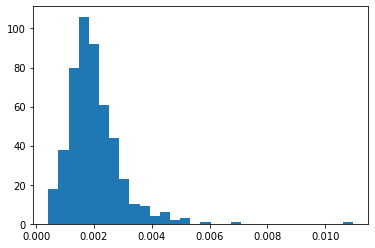

In [ ]:
sample_nearest = np.asarray(smallest_in_arr(find_distances(ER)))
prob_nearest = sample_nearest/sum(sample_nearest)
plt.hist(prob_nearest, bins = 30)
plt.show()

In [ ]:
shape_params = np.arange(3,7)
scale_params = np.logspace(1,100,100)
points = prob_nearest.shape[0]
KL_score, best_shape, best_scale = KL_gridSearch(points,shape_params, scale_params, prob_nearest)
print(best_shape, best_scale)

count: 1 shape: 3 scale: 10.0 score: 0.29166176619065853
count: 6 shape: 3 scale: 1000000.0 score: 0.28800350106016953
count: 7 shape: 3 scale: 10000000.0 score: 0.2840421053755528
count: 94 shape: 3 scale: 1e+94 score: 0.27951474502325796
count: 101 shape: 4 scale: 10.0 score: 0.27553804441093926
count: 103 shape: 4 scale: 1000.0 score: 0.26426522195042434
count: 119 shape: 4 scale: 1e+19 score: 0.2636021224605492
count: 201 shape: 5 scale: 10.0 score: 0.2629987321918935
count: 202 shape: 5 scale: 100.0 score: 0.25652390796414015
count: 203 shape: 5 scale: 1000.0 score: 0.2514504261524099
count: 253 shape: 5 scale: 1e+53 score: 0.25065940446006446
count: 261 shape: 5 scale: 1e+61 score: 0.24561867417287506
count: 305 shape: 6 scale: 100000.0 score: 0.24477627647992048
count: 306 shape: 6 scale: 1000000.0 score: 0.24091816675752722
count: 324 shape: 6 scale: 1e+24 score: 0.2387942192180156
count: 360 shape: 6 scale: 1e+60 score: 0.238298962370869
6 1e+60


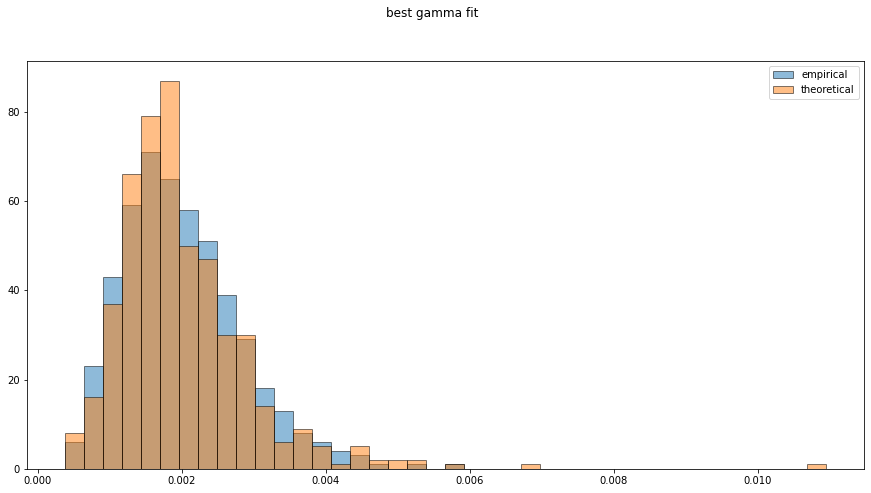

In [ ]:
zero_list = random_avger(points,best_shape,best_scale)
fig, ax = plt.subplots(1,1, figsize = (15,7.5))
bins=np.histogram(np.hstack((zero_list,prob_nearest)), bins=40)[1]
ax.hist(zero_list, bins, alpha = 0.5, edgecolor = "black", label = "empirical")
ax.hist(prob_nearest, bins, alpha = 0.5, edgecolor = "black", label = "theoretical")
fig.suptitle("best gamma fit")
plt.legend()

In [ ]:
print("area of empirical:", sp.integrate.simps(prob_nearest))
print("area of theoretical:", sp.integrate.simps(zero_list))

area of empirical: 0.9895979771304608
area of theoretical: 0.9968171643519201


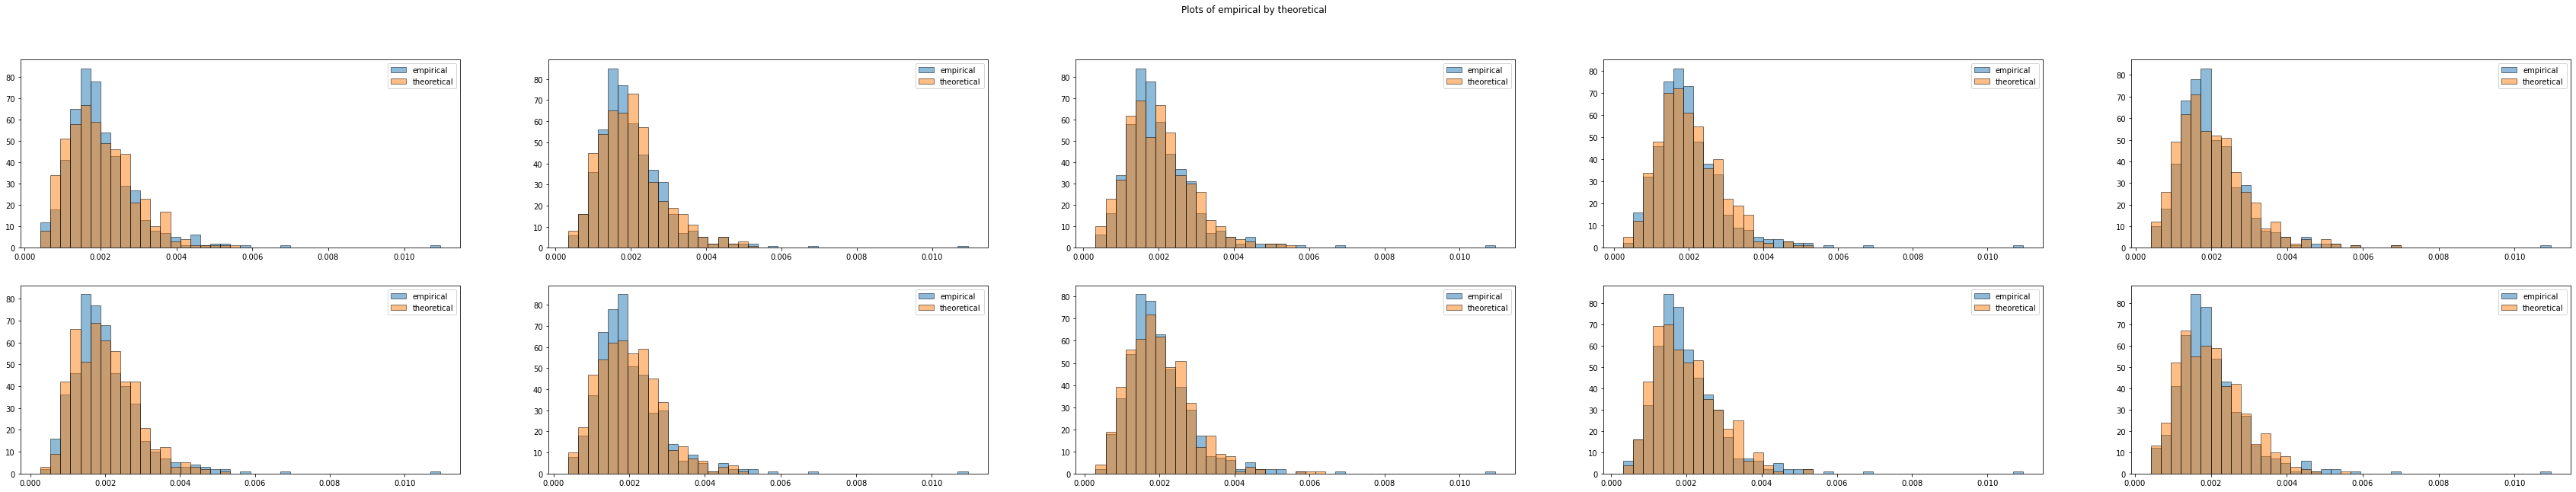

In [ ]:
subplots(best_shape, best_scale)

In [ ]:
low_shape = random_avger(points,best_shape, best_scale)
high_shape = random_avger(points,999, best_scale)
print("low shape entropy:", sp.stats.entropy(low_shape, prob_nearest))
print("high shape entopy:", sp.stats.entropy(high_shape, prob_nearest))
print("low shape kl divergence:", kl_divergence(low_shape, prob_nearest))
print("high shape kl divergence:", kl_divergence(high_shape, prob_nearest))

# print("low shape kl divergence:", kl(low_shape, prob_nearest))
# print("high shape kl divergence:", kl(high_shape, prob_nearest))

low shape entropy: 0.17466491883602656
high shape entopy: 0.09333247481120746
low shape kl divergence: 0.2519882122220097
high shape kl divergence: 0.13465029856402394


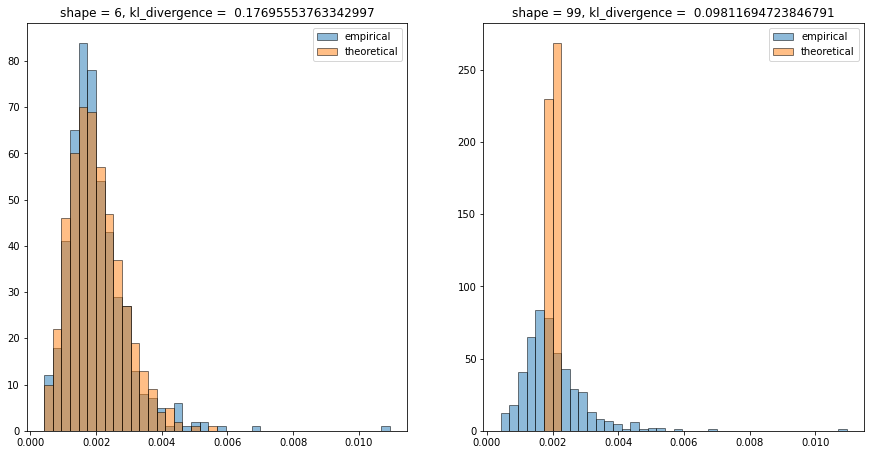

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,7.5))
bins1=np.histogram(np.hstack((low_shape,prob_nearest)), bins=40)[1]
bins2=np.histogram(np.hstack((high_shape,prob_nearest)), bins=40)[1]

ax[0].hist(prob_nearest, bins1, alpha = 0.5, label = "empirical", edgecolor = "black")
ax[0].hist(low_shape, bins1, alpha = 0.5, label = "theoretical", edgecolor = "black")
ax[0].title.set_text("shape = 6, kl_divergence =  0.17695553763342997")

ax[1].hist(prob_nearest, bins2, alpha = 0.5, label = "empirical", edgecolor = "black")
ax[1].hist(high_shape, bins2, alpha = 0.5, label = "theoretical", edgecolor = "black")
ax[1].title.set_text("shape = 99, kl_divergence =  0.09811694723846791")


ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
bins = 40
print(return_intersection(low_shape, prob_nearest, bins))
print(return_intersection(high_shape, prob_nearest,bins))
shape, loc, scale = calculateGammaParams(prob_nearest)
estimated = random_avger(points, shape, scale)
print(return_intersection(prob_nearest, estimated,bins))
print(shape)

8.421864532037155e-06
1.7560439798330496e-05
6.7796481331645136e-06
4.462629976016887


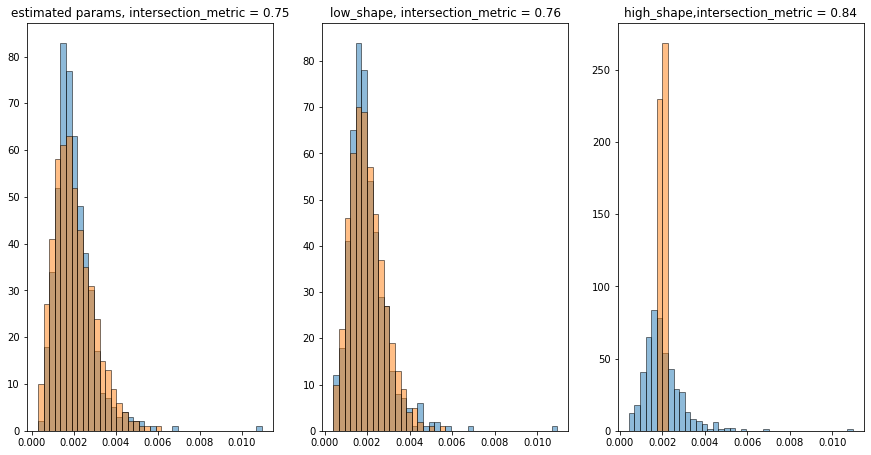

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7.5))
bins1=np.histogram(np.hstack((estimated,prob_nearest)), bins=40)[1]
bins2=np.histogram(np.hstack((low_shape,prob_nearest)), bins=40)[1]

ax[0].hist(prob_nearest, bins1, alpha = 0.5, label = "empirical", edgecolor = "black")
ax[0].hist(estimated, bins1, alpha = 0.5, label = "theoretical", edgecolor = "black")
ax[0].title.set_text("estimated params, intersection_metric = 0.75")


ax[1].hist(prob_nearest, bins2, alpha = 0.5, label = "empirical", edgecolor = "black")
ax[1].hist(low_shape, bins2, alpha = 0.5, label = "theoretical", edgecolor = "black")
ax[1].title.set_text("low_shape, intersection_metric = 0.76")

ax[2].hist(prob_nearest, bins2, alpha = 0.5, label = "empirical", edgecolor = "black")
ax[2].hist(high_shape, bins2, alpha = 0.5, label = "theoretical", edgecolor = "black")
ax[2].title.set_text("high_shape,intersection_metric = 0.84")